Using device: cpu
Epoch 1/10, Loss: 0.6003, Accuracy: 68.18%
Epoch 2/10, Loss: 0.5166, Accuracy: 74.51%
Epoch 3/10, Loss: 0.4213, Accuracy: 81.09%
Epoch 4/10, Loss: 0.4306, Accuracy: 82.47%
Epoch 5/10, Loss: 0.4260, Accuracy: 82.31%
Epoch 6/10, Loss: 0.3461, Accuracy: 85.47%
Epoch 7/10, Loss: 0.4278, Accuracy: 82.55%
Epoch 8/10, Loss: 0.3894, Accuracy: 85.15%
Epoch 9/10, Loss: 0.3895, Accuracy: 83.69%
Epoch 10/10, Loss: 0.3565, Accuracy: 83.36%

=== Evaluation Metrics ===
Test Loss: 0.2706
Accuracy: 91.59%
              precision    recall  f1-score   support

      Benign       0.97      0.93      0.95       284
   Malignant       0.49      0.72      0.58        25

    accuracy                           0.92       309
   macro avg       0.73      0.83      0.77       309
weighted avg       0.93      0.92      0.92       309

F1: 0.5806, Precision: 0.4865, Recall: 0.7200


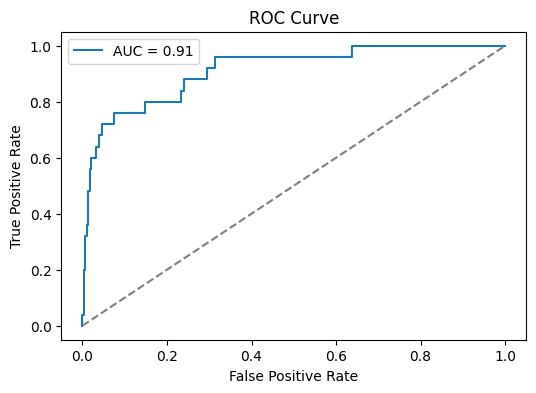


=== Predictions on Individual Images ===
8864_idx5_x1801_y2701_class1.png: Malignant
8864_idx5_x1801_y2751_class1.png: Malignant
8864_idx5_x1801_y2901_class0.png: Benign
8864_idx5_x1851_y1401_class0.png: Benign
8864_idx5_x1851_y1601_class0.png: Benign
8864_idx5_x1851_y1_class0.png: Benign
8864_idx5_x1851_y2001_class1.png: Benign
8864_idx5_x1851_y2051_class1.png: Benign
8864_idx5_x1851_y2101_class1.png: Malignant
8864_idx5_x1851_y2151_class1.png: Malignant
8864_idx5_x1851_y2201_class1.png: Malignant
8864_idx5_x1851_y2251_class1.png: Malignant
8864_idx5_x1851_y2301_class1.png: Malignant
8864_idx5_x1851_y2351_class1.png: Malignant
8864_idx5_x1851_y2401_class1.png: Malignant
8864_idx5_x1851_y2451_class1.png: Malignant
8864_idx5_x1851_y2501_class1.png: Malignant
8864_idx5_x1851_y2551_class1.png: Malignant
8864_idx5_x1851_y2601_class1.png: Malignant
8864_idx5_x1851_y2651_class1.png: Malignant
8864_idx5_x1851_y2701_class1.png: Malignant
8864_idx5_x1851_y2751_class1.png: Malignant
8864_idx5_x

In [1]:
# ======================== 1. IMPORTS & CONFIG ========================
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve, auc, f1_score, accuracy_score, precision_score, recall_score
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ======================== 2. CUSTOM OPTIMIZER ========================
class ParrotOptimizer(torch.optim.Optimizer):
    def __init__(self, params, lr=0.01, alpha=0.9):
        defaults = dict(lr=lr, alpha=alpha)
        super(ParrotOptimizer, self).__init__(params, defaults)

    def step(self, closure=None):
        for group in self.param_groups:
            alpha = group['alpha']
            lr = group['lr']
            for p in group['params']:
                if p.grad is None:
                    continue
                if 'velocity' not in self.state[p]:
                    self.state[p]['velocity'] = torch.zeros_like(p.data)
                velocity = self.state[p]['velocity']
                velocity.mul_(alpha).add_(p.grad)
                p.data.add_(-lr * velocity)

# ======================== 3. LIQUID NEURAL NETWORK ========================
class LiquidTimeConstantNeuron(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LiquidTimeConstantNeuron, self).__init__()
        self.W_in = nn.Linear(input_size, hidden_size)
        self.W_rec = nn.Linear(hidden_size, hidden_size)
        self.tau = nn.Parameter(torch.ones(hidden_size))
        self.hidden_size = hidden_size

    def forward(self, x):
        batch_size = x.size(0)
        h = torch.zeros(batch_size, self.hidden_size, device=x.device)
        outputs = []
        for _ in range(10):
            dh = (-h + torch.tanh(self.W_in(x) + self.W_rec(h))) / self.tau
            h = h + dh
            outputs.append(h.unsqueeze(1))
        return torch.cat(outputs, dim=1).mean(dim=1)

class LiquidNN(nn.Module):
    def __init__(self, input_dim=3*128*128, hidden_dim=64):
        super().__init__()
        self.flatten = nn.Flatten()
        self.input_fc = nn.Linear(input_dim, hidden_dim)
        self.liquid = LiquidTimeConstantNeuron(hidden_dim, hidden_dim)
        self.output_fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.flatten(x)
        x = torch.relu(self.input_fc(x))
        x = self.liquid(x)
        return torch.sigmoid(self.output_fc(x))

# ======================== 4. DATASET CLASS ========================
class CholangiocarcinomaDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        class_names = sorted(os.listdir(root_dir))
        self.class_map = {name: i for i, name in enumerate(class_names)}
        for class_name in class_names:
            class_path = os.path.join(root_dir, class_name)
            for img_file in os.listdir(class_path):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(class_path, img_file))
                    self.labels.append(self.class_map[class_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]

# ======================== 5. TRANSFORMS ========================
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# ======================== 6. DATA LOADING ========================
dataset_path = r"C:\\Users\\ujjaw\\Desktop\\Project\\archive\\8918"
dataset = CholangiocarcinomaDataset(dataset_path, transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_labels = [dataset[i][1] for i in train_dataset.indices]
class_weights = 1.0 / np.bincount(train_labels)
sample_weights = [class_weights[label] for label in train_labels]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# ======================== 7. TRAIN FUNCTION ========================
def train_model(model, optimizer, num_epochs=10):
    criterion = nn.BCELoss()
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device, dtype=torch.float32).unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")

# ======================== 8. EVALUATION FUNCTION ========================
def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_pred, y_probs = [], [], []
    criterion = nn.BCELoss()
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device, dtype=torch.float32).unsqueeze(1)
            outputs = model(images)
            test_loss += criterion(outputs, labels).item()
            y_probs.extend(outputs.cpu().numpy())
            y_pred.extend((outputs > 0.5).cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    print(f"\n=== Evaluation Metrics ===\nTest Loss: {test_loss / len(test_loader):.4f}")
    print(f"Accuracy: {accuracy_score(y_true, y_pred)*100:.2f}%")
    print(classification_report(y_true, y_pred, target_names=["Benign", "Malignant"]))
    print(f"F1: {f1_score(y_true, y_pred):.4f}, Precision: {precision_score(y_true, y_pred):.4f}, Recall: {recall_score(y_true, y_pred):.4f}")

    fpr, tpr, _ = roc_curve(y_true, y_probs)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.2f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

# ======================== 9. PREDICT SINGLE IMAGE ========================
def predict_image(model, image_path, transform):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image).item()
    return "Malignant" if output > 0.5 else "Benign"

# ======================== 10. RUN PIPELINE ========================
model = LiquidNN()
optimizer = ParrotOptimizer(model.parameters(), lr=0.01, alpha=0.9)

train_model(model, optimizer, num_epochs=10)
evaluate_model(model, test_loader)

image_dir = r"C:\\Users\\ujjaw\\project minor\\testingdataset"
print("\n=== Predictions on Individual Images ===")
for img in os.listdir(image_dir):
    if img.lower().endswith(('.png', '.jpg', '.jpeg')):
        path = os.path.join(image_dir, img)
        pred = predict_image(model, path, transform)
        print(f"{img}: {pred}")
